In [2]:
import pandas as pd
import psycopg2
import config as c
import pandas.io.sql as sqlio

In [3]:
conn = psycopg2.connect(host=c.host,
                        database=c.data_base,
                        user=c.user_name,
                        password=c.password
                        )

## Quation 1
We think there is a seasonality factor to our NPS data for tradesman. Splice the data and show how seasonality affects our service, giving an example or two as to why NPS may go up/down throughout the year.

In [4]:
query_quarterly = """
WITH final_table AS (

		WITH mid_table AS 
			( 
			SELECT cohort_year, cohort_quarter, AVG(net_promoter_score) as quarterly_average_score 
			FROM 
				(SELECT 
				DATE_PART('quarter',end_of_period) as cohort_quarter, 
				DATE_PART('year',end_of_period) AS cohort_year,*
				FROM customer_happiness_cohorts
				WHERE type = 'tradesman') t
			GROUP BY cohort_year,cohort_quarter
			ORDER BY quarterly_average_score DESC
			) 
			SELECT 
				cohort_year,cohort_quarter, 
				quarterly_average_score, 
				AVG(quarterly_average_score) OVER (order by cohort_year, cohort_quarter rows between 1 preceding and 2 following) as moving_average 
			FROM mid_table
			order by cohort_year, cohort_quarter asc
			)
SELECT 
	cohort_year,cohort_quarter, 
	quarterly_average_score/moving_average AS seasonal_index,
	quarterly_average_score,
	moving_average
FROM final_table
ORDER BY seasonal_index DESC
;
"""

In [8]:
data = sqlio.read_sql_query(query_quarterly, conn)

In [24]:
pd.to_datetime('2015Q1').to_period('Q')

Period('2015Q1', 'Q-DEC')

In [25]:
data["period"] = data["cohort_year"].map(str) + data["cohort_quarter"].map(str)

In [127]:
data.head()

,user_rank,count_users,county
0,Other,1820,London
1,Other,1195,Essex
2,Other,1113,Lancashire
3,Other,1110,Kent
4,Detractor,908,London


In [29]:
from ggplot import *

/Users/giacomo.vannucchi/miniconda3/envs/facebook_data_package/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/giacomo.vannucchi/miniconda3/envs/facebook_data_package/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


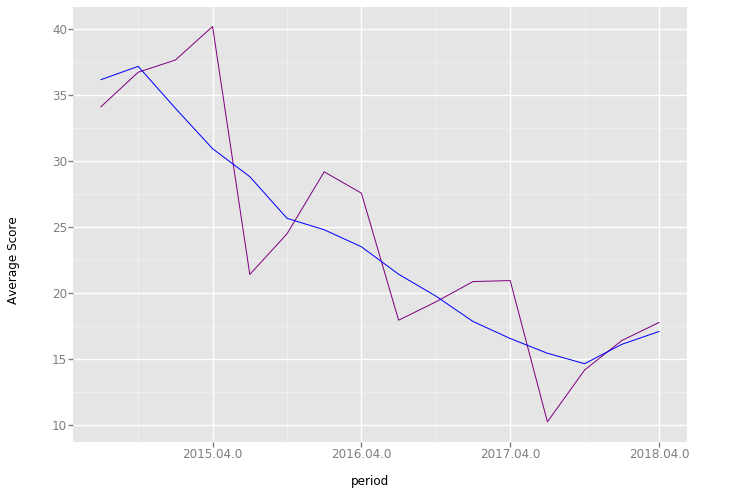

<ggplot: (-9223372029299397116)>

In [72]:
ggplot(aes(x='period'), data = data)+\
        geom_line(aes(y='quarterly_average_score', color='purple'))+\
        geom_line(aes(y='moving_average', color='blue'))+\
        scale_x_continuous(breaks = (3,7,11,15))+\
        ylab('Average Score')

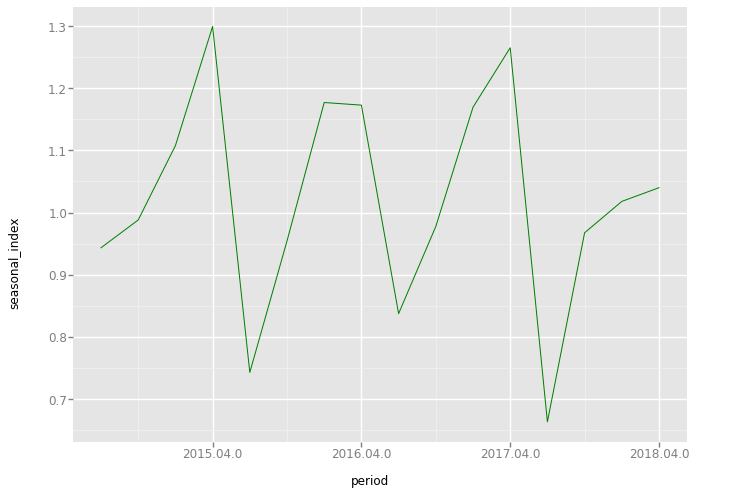

<ggplot: (-9223372029299506979)>

In [75]:
ggplot(aes(x='period', y='seasonal_index'), data = data)+\
        geom_line(color='green')+\
        scale_x_continuous(breaks = (3,7,11,15))

### Question 1: Answer
The final_table shows the seasonality index of NPS for each quarter. 
An index abobe 1 means that the quarter has a performance higher than average trend, while an index below 1 shows the opposite, which means the quarter performed below average trend.

As we can see from the final_table the best performing quarters in terms of NPS are Q3 and Q4, consistently over the years. Q2 is consistently scoring an NPS average trend in the middle over the years, while Q1 has been the low performing quarter across all years.

We can thereore conclude that there is a clear seasonality effect in the data, with NPS going down in the first Q1 and then progressivly going up until reaching its max on Q3 and Q4.


## Question 2
Marketing comes to the tech team and says that they want to run a campaign to to
get more tradespeople on the site. Given the data from NPS, what recommendation
would you make as to which types and locations they should focus on and why?

In [436]:
query_2 = """
WITH ranked_users_table AS (
SELECT id, user_id, 
	CASE
		WHEN rating < 7 THEN 'Detractor'
		WHEN rating > 8 THEN 'Promoter'
		ELSE 'Passive'
	END as user_rank
FROM customer_happiness_questions
 ) SELECT 
 	user_rank, 
 	COUNT(DISTINCT rut.user_id) AS count_users,
 	tl.county
 	FROM ranked_users_table rut
 	JOIN tradesman_locations tl ON tl.user_id = rut.user_id
 	JOIN (
 		SELECT *, 
		RANK() OVER (order by pref_rank)
		FROM tradesmen_trades 
 		)tt ON tl.user_id = tt.user_id -- using only top ranked trade for simplicity
 	WHERE tt.rank = 1 
 	GROUP BY rut.user_rank, tl.county
 	ORDER BY count_users DESC
 ;
"""

In [449]:
data_2 = sqlio.read_sql_query(query_2, conn)

In [450]:
data_2.head()

,user_rank,count_users,county
0,Promoter,1475,London
1,Promoter,924,Essex
2,Detractor,908,London
3,Promoter,863,Kent
4,Promoter,844,Lancashire


In [451]:
### Let's have a look at the distribution of tradesmen in each area and group small areas into a "Generic_county" group

In [452]:
county_size = data_2.groupby(['county']).agg({'count_users': 'sum'}).reset_index()

In [453]:
county_size = county_size.sort_values(by = ['count_users'], ascending=False)

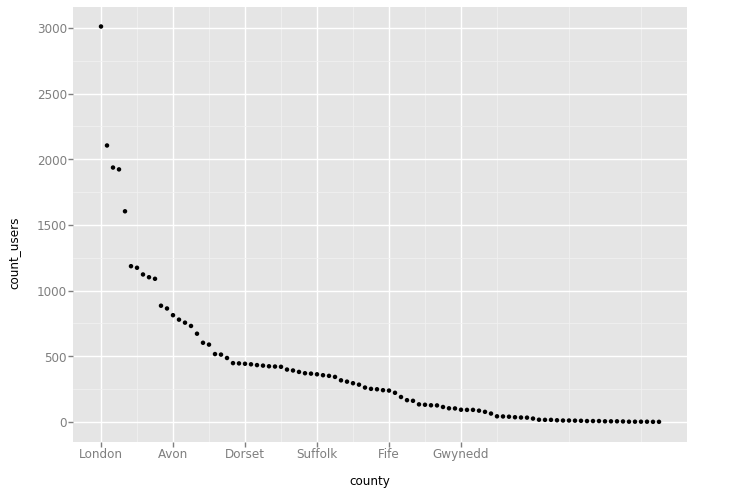

<ggplot: (-9223372029288243270)>

In [454]:
ggplot(aes(x = "county", y = "count_users"),data = county_size)+\
        geom_point()+\
        scale_x_continuous(breaks = (0,12,24,36,48,60))

In [455]:
## Let's use 200 users are the breakpoint
small_counties = county_size[county_size["count_users"] <= 200]["county"].unique().tolist()

In [456]:
data_2.loc[data_2.county.isin(small_counties), 'county'] = 'Generic_county'

In [457]:
data_2["county"].unique()

array(['London', 'Essex', 'Kent', 'Lancashire', 'Surrey', 'Middlesex',
       'West Yorkshire', 'West Midlands', 'Hertfordshire', 'Hampshire',
       'Devon', 'Cheshire', 'Lanarkshire', 'Avon', 'Merseyside',
       'Nottinghamshire', 'South Yorkshire', 'Staffordshire',
       'East Sussex', 'Tyne and Wear', 'Berkshire', 'West Sussex',
       'Cambridgeshire', 'Cornwall', 'Mid Glamorgan', 'Gloucestershire',
       'Bedfordshire', 'Derbyshire', 'Wiltshire', 'Northamptonshire',
       'Norfolk', 'Dorset', 'Gwent', 'Buckinghamshire', 'Somerset',
       'Suffolk', 'Lincolnshire', 'Leicestershire', 'Oxfordshire',
       'Midlothian', 'County Durham', 'Worcestershire', 'South Glamorgan',
       'Fife', 'West Glamorgan', 'Dyfed', 'North Yorkshire',
       'North Humberside', 'Clwyd', 'Shropshire', 'Generic_county'],
      dtype=object)

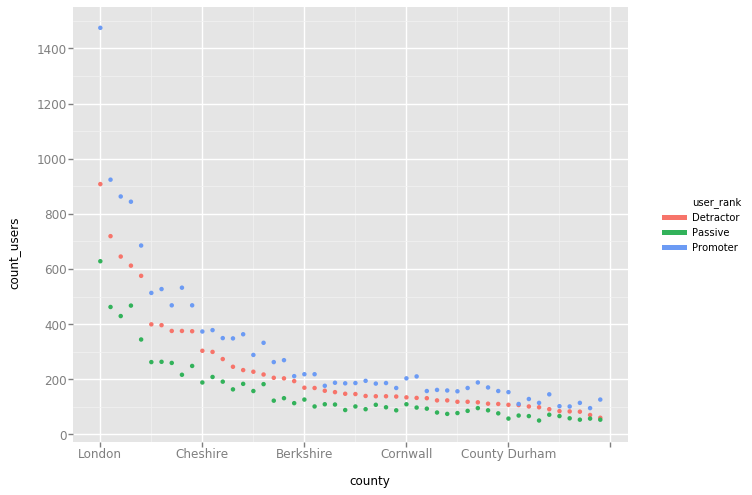

<ggplot: (-9223372029288243410)>

In [458]:
ggplot(aes(x = "county", y = "count_users", color = 'user_rank'),data = data_2[data_2["county"] != "Generic_county"])+\
        geom_point()+\
        scale_x_continuous(breaks = (0,10,20,30,40,50))

In [407]:
# Let's have a look at the counties with higher percentage of detractors

In [459]:
counties = data_2.groupby(['county', 'user_rank']).agg({'count_users': 'sum'})

In [474]:
counties_pcts = counties.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

In [476]:
counties_pcts = counties_pcts.rename(columns={"count_users": "percent_users"})

In [478]:
counties_pcts = counties_pcts.reset_index()

In [481]:
counties_pcts[counties_pcts['user_rank'] == 'Detractor'].sort_values(by = ['percent_users'], ascending=False).head(10)

,county,user_rank,percent_users
135,West Glamorgan,Detractor,37.404580
141,West Sussex,Detractor,37.330754
99,North Yorkshire,Detractor,37.323944
129,Surrey,Detractor,35.847880
33,Dorset,Detractor,35.665914
15,Cheshire,Detractor,35.069444
102,Northamptonshire,Detractor,35.000000
9,Buckinghamshire,Detractor,34.948980
39,East Sussex,Detractor,34.804754
75,Lincolnshire,Detractor,34.550562


#### Above is the list of the 10 Counties with the higher % of Detractors respect to the total of reviews. (excluding small counties)

# Now look into each one of these and see if any particular trade